In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
import pathlib
import dateutil

In [3]:
import numpy as np

In [4]:
import pandas as pd

In [5]:
import xarray as xr

In [6]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [7]:
import tensorflow as tf

In [8]:
from tensorflow import keras

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [10]:
from cartopy import crs as ccrs

### read the Southern Oscillation Index (NIWA)

#### This particular version has been calculated wit respect to the 1981 - 2010 climatology. See [here](https://github.com/nicolasfauchereau/CPP_indices/tree/master/notebooks/SOI) for the calculation of the NIWA SOI using the Troup method

In [11]:
soi = pd.read_csv('./data/SOI.csv', index_col=0, parse_dates=True)

In [12]:
soi.head()

,SOI
1876-01-01,1.022749
1876-02-01,0.989125
1876-03-01,0.377561
1876-04-01,0.927624
1876-05-01,0.963654


### Now loads the PNA, NINO3 and NINO34 indices, all taken from the KNMI climate explorer (see [https://climexp.knmi.nl/selectindex.cgi?id=someone@somewhere](https://climexp.knmi.nl/selectindex.cgi?id=someone@somewhere))

#### small function to load and format the timeseries 

In [13]:
def make_index(filename, name=None):
    dset  = xr.open_dataset(filename, decode_times=False)
    start_date = pd.to_datetime(dset.time.attrs['units'].split()[-1])
    index = dset.to_dataframe()
    index.columns = [name]
    index.index = pd.date_range(start=start_date.strftime("%Y-%m"), freq='MS', periods=len(index))
    return index

In [14]:
pna = make_index('./data/icpc_pna.nc', name='PNA')

In [15]:
nino3 = make_index('./data/iersst_nino3a.nc', name='NINO3')

In [16]:
nino34 = make_index('./data/iersst_nino3.4a.nc', name='NINO34')

### concatenate along the columns axis

In [17]:
df = pd.concat([soi, nino3, nino34, pna], axis=1)

### drop the missing values

In [18]:
df = df.dropna(axis=0)

### keep 1979 onward

In [19]:
df = df.loc['1979':,:]

### plot 

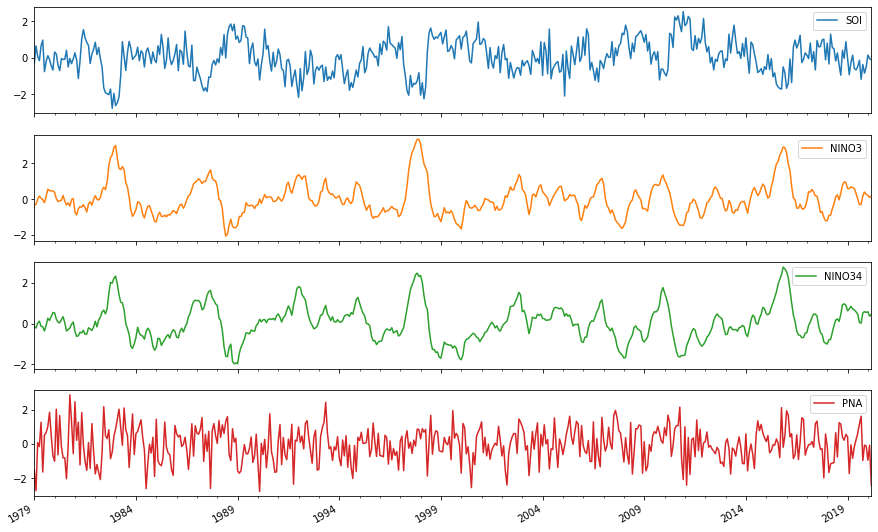

In [20]:
df.plot(subplots=True, sharex=True, figsize=(15, 10));

### get the monthly precipitation dataset (GPCP, retrieved from [https://psl.noaa.gov/data/gridded/data.gpcp.html](https://psl.noaa.gov/data/gridded/data.gpcp.html))

In [21]:
precip = xr.open_dataset('./data/precip.mon.mean.nc')

In [22]:
precip

<xarray.Dataset>
Dimensions:    (lat: 72, lon: 144, nv: 2, time: 495)
Coordinates:
  * lat        (lat) float32 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * lon        (lon) float32 1.25 3.75 6.25 8.75 ... 351.25 353.75 356.25 358.75
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2020-03-01
Dimensions without coordinates: nv
Data variables:
    time_bnds  (time, nv) datetime64[ns] ...
    lat_bnds   (lat, nv) float32 ...
    lon_bnds   (lon, nv) float32 ...
    precip     (time, lat, lon) float32 ...
Attributes:
    Conventions:           CF-1.0
    curator:               Dr. Jian-Jian Wang\nESSIC, University of Maryland ...
    citation:              Adler, R.F., G.J. Huffman, A. Chang, R. Ferraro, P...
    title:                 GPCP Version 2.3 Combined Precipitation Dataset (F...
    platform:              NOAA POES (Polar Orbiting Environmental Satellites)
    source_obs:            CDR RSS SSMI/SSMIS Tbs over ocean \nCDR SSMI/SSMIS...
    documentation:         http://www.esrl.noaa.gov/psd/data/gridded/data.gpc...
    version:               V2.3
    Acknowledgement:       \n
    contributor_name:      Robert Adler    University of Maryland \nGeorge Hu...
    dataset_title:         Global Precipitation Climatology Project (GPCP) Mo...
    description:           https://data.nodc.noaa.gov/cgi-bin/iso?id=gov.noaa...
    source:                https://www.ncei.noaa.gov/data/global-precipitatio...
    source_documentation:  https://www.ncdc.noaa.gov/cdr/atmospheric/precipit...
    NCO:                   4.6.9
    history:               Generated at NOAA/ESRL PSD Sep 9 2016 based on dat...
    data_comment:          Interim data covers 2020/02 through latest.
    References:            http://www.psl.noaa.gov/data/gridded/data.gpcp.html

### calculate the monthly anomalies, WRT the 1981 - 2010 climatological period 

### define small function to remove the average 

In [23]:
def demean(x): 
    return x - x.sel(time=slice('1981-01-01','2010-12-01')).mean('time')

### use the groupby mechanism to calculate the anomalies WRT to each month's climatology

In [24]:
precip_anomalies = precip.groupby('time.month').apply(demean)

### example: precipitation anomalies in January 1998 (during the peak of the 1997- 1998 El Nino event)

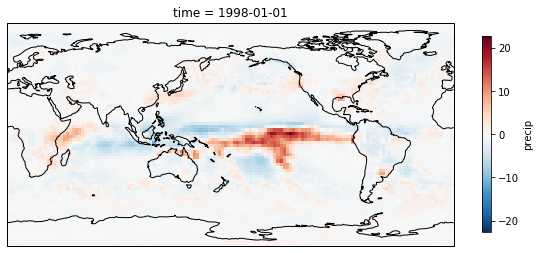

In [25]:
f, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)}, figsize=(10,6))
precip_anomalies.sel(time='1998-01-01')['precip'].plot(ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs={'shrink':0.6})
ax.coastlines()

### Now defines a function to do the regression (SOI on Precipitation)

In [26]:
def lag_linregress_xarray(x, y, lagx=0, lagy=0):
    """
    
    see http://hrishichandanpurkar.blogspot.com/2017/
    
    Calculates the regression metrics: 
    
    Covariance, correlation, regression slope and intercept, p-value, and standard error on regression
    
    between 2 xarray DataArrays along the time dimension 
    
    Arguments
    ---------
    
    x : xr.DataArray, the independant ND DataArray, must contain a time dimension 
    y : xr.DataArray, the dependant ND DataArray, must contain a time dimension 
    lagx : the time shift in x (signed integer)
    lagy : the time shift in y (signed integer)
    
    Return
    ------
    
    Covariance
    correlation
    regression
    slope
    intercept
    p-value
    standard error on regression
    
    """ 
    
    import numpy as np
    import xarray as xr
    from scipy.stats import t
    
    # Ensure that the data are properly alinged to each other. 
    x,y = xr.align(x,y)
    
    # Add lag information if any, and shift the data accordingly
    if lagx != 0:
        # If x lags y by 1, x must be shifted 1 step backwards. 
        # But as the 'zero-th' value is nonexistant, xr assigns it as invalid (nan). Hence it needs to be dropped
        x   = x.shift(time = -lagx).dropna(dim='time')
        # Next important step is to re-align the two datasets so that y adjusts to the changed coordinates of x
        x,y = xr.align(x,y)

    if lagy!=0:
        y   = y.shift(time = -lagy).dropna(dim='time')
        x,y = xr.align(x,y)
 
    # Compute data length, mean and standard deviation along time axis for further use: 
    n     = x.shape[0]
    xmean = x.mean(axis=0)
    ymean = y.mean(axis=0)
    xstd  = x.std(axis=0)
    ystd  = y.std(axis=0)
    
    # Compute covariance along time axis
    cov   =  np.sum((x - xmean)*(y - ymean), axis=0)/(n)
    
    # Compute correlation along time axis
    cor   = cov/(xstd*ystd)
    
    # Compute regression slope and intercept:
    slope     = cov/(xstd**2)
    intercept = ymean - xmean*slope  
    
    # Compute P-value and standard error
    # Compute t-statistics
    
    tstats = cor*np.sqrt(n-2)/np.sqrt(1-cor**2)
    
    stderr = slope/tstats
    
    pval   = t.sf(tstats, n-2)*2
    
    pval   = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)

    return cov,cor,slope,intercept,pval,stderr

#### select the SOI for the time period matching the precipitation dataset (1979 - 2020-03)

In [27]:
df.index.name = 'time'

In [28]:
df.loc[precip_anomalies.time.to_index(),:]

,SOI,NINO3,NINO34,PNA
time,,,,
1979-01-01,-0.302270,-0.329605,-0.141552,-1.54
1979-02-01,0.658600,-0.291544,-0.211416,-2.73
1979-03-01,0.085883,-0.010796,0.031036,0.08
1979-04-01,-0.154270,0.170126,0.125408,-0.15
1979-05-01,0.655285,0.045315,-0.124941,1.27
...,...,...,...,...
2019-11-01,-0.843285,0.393145,0.594463,-0.07
2019-12-01,-0.482897,0.270660,0.555216,-0.12
2020-01-01,0.153205,0.209755,0.588638,-0.95


In [29]:
df_xr = df.to_xarray()

In [30]:
df_xr

<xarray.Dataset>
Dimensions:  (time: 495)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2020-03-01
Data variables:
    SOI      (time) float64 -0.3023 0.6586 0.08588 ... 0.1532 -0.03917 -0.1086
    NINO3    (time) float32 -0.329605 -0.291544 ... 0.0891247 0.185196
    NINO34   (time) float32 -0.141552 -0.211416 0.0310364 ... 0.367104 0.464775
    PNA      (time) float32 -1.54 -2.73 0.08 -0.15 ... -0.12 -0.95 -0.07 -2.41

In [31]:
precip_anomalies

<xarray.Dataset>
Dimensions:   (lat: 72, lon: 144, nv: 2, time: 495)
Coordinates:
  * lat       (lat) float32 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * lon       (lon) float32 1.25 3.75 6.25 8.75 ... 351.25 353.75 356.25 358.75
  * time      (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2020-03-01
Dimensions without coordinates: nv
Data variables:
    lat_bnds  (time, lat, nv) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    lon_bnds  (time, lon, nv) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    precip    (time, lat, lon) float32 -0.021214118 -0.034559034 ... 0.10364504

### do the regression at lag 0 for the SOI 

In [32]:
cov,cor,slope,intercept,pval,stderr = lag_linregress_xarray(x=df_xr['SOI'], y=precip_anomalies['precip'])

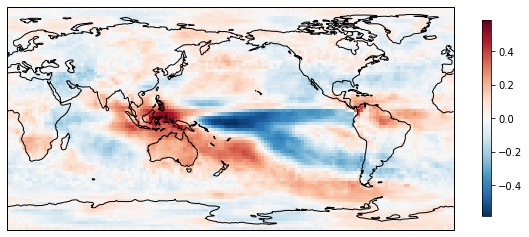

In [33]:
f, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)}, figsize=(10,6))
cor.plot(ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs={'shrink':0.6})
ax.coastlines()

### same thing for NINO3.4 

In [34]:
cov,cor,slope,intercept,pval,stderr = lag_linregress_xarray(x=df_xr['NINO34'], y=precip_anomalies['precip'])

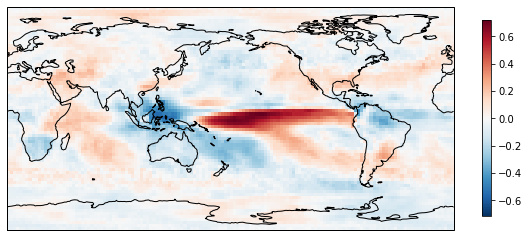

In [35]:
f, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)}, figsize=(10,6))
cor.plot(ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs={'shrink':0.6})
ax.coastlines()

### we care about the absolute correlation

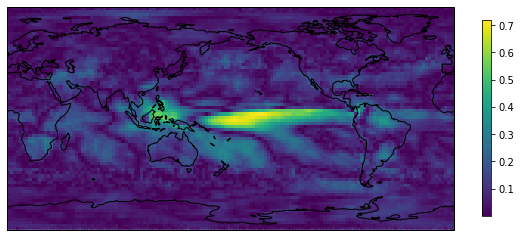

In [36]:
f, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)}, figsize=(10,6))
np.abs(cor).plot(ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs={'shrink':0.6})
ax.coastlines()

### find the maximum (absolute) correlation 

In [37]:
abs_cor = np.abs(cor)

In [38]:
find_max = abs_cor.where(abs_cor==abs_cor.max(), drop=True).squeeze()

In [39]:
find_max

<xarray.DataArray ()>
array(0.71674552)
Coordinates:
    lat      float32 3.75
    lon      float32 203.75

In [41]:
ts_precip = precip_anomalies.sel(lat=find_max.lat.data, lon=find_max.lon.data)

### casts into a dataframe 

In [42]:
ts_precip = ts_precip['precip'].to_dataframe()[['precip']]

In [43]:
ts_precip.head()

,precip
time,
1979-01-01,-0.782460
1979-02-01,1.735033
1979-03-01,1.261271
1979-04-01,-4.773498
1979-05-01,1.368517


In [44]:
df.loc[:,'precip'] = ts_precip

In [45]:
df.head()

,SOI,NINO3,NINO34,PNA,precip
time,,,,,
1979-01-01,-0.302270,-0.329605,-0.141552,-1.54,-0.782460
1979-02-01,0.658600,-0.291544,-0.211416,-2.73,1.735033
1979-03-01,0.085883,-0.010796,0.031036,0.08,1.261271
1979-04-01,-0.154270,0.170126,0.125408,-0.15,-4.773498
1979-05-01,0.655285,0.045315,-0.124941,1.27,1.368517


### Now standardize (mean = 0, std = 1) everything 

### we can use scikit-learn `StandardScaler` for this, it can take a pandas `DataFrame` in, but returns a numpy `ndarray` 

In [46]:
from sklearn.preprocessing import StandardScaler

In [47]:
scaler = StandardScaler()

In [48]:
x = scaler.fit_transform(df)

In [49]:
df_std = pd.DataFrame(x, index=df.index, columns=df.columns)

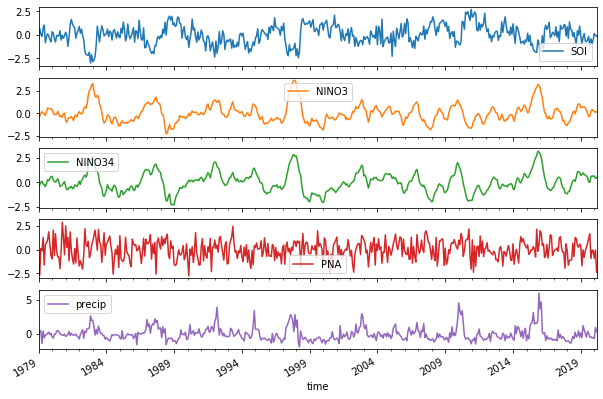

In [50]:
df_std.plot(subplots=True, sharex=True, figsize=(10, 7));

### correlation (0 lag)

In [51]:
df_std.corr()

,SOI,NINO3,NINO34,PNA,precip
SOI,1.000000,-0.640380,-0.703533,-0.129828,-0.492453
NINO3,-0.640380,1.000000,0.941931,0.152101,0.677860
NINO34,-0.703533,0.941931,1.000000,0.129831,0.716745
PNA,-0.129828,0.152101,0.129831,1.000000,0.149736
precip,-0.492453,0.677860,0.716745,0.149736,1.000000


### OK so now we follow the original ESRI notebook 

In [52]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    This method takes a time series and returns transformed data.
    data: time series as pandas dataframe
    n_in: number of previous time steps as input (X)
    n_out: number of next time steps as output (y)
    dropnan: whether or not to drop rows with NaN values
    """

    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i).iloc[:,-1])
        if i == 0:
            names += ['VAR(t)']
        else:
            names += ['VAR(t+%d)' % i]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

### get the values 

In [53]:
enso = df_std.values.astype('float32')

### define the parameters for the above function 

In [54]:
lag = 12
ahead = 3
n_features = 1

In [55]:
reframed = series_to_supervised(enso, lag, ahead)

In [56]:
reframed.head()

,var1(t-12),var2(t-12),var3(t-12),var4(t-12),var5(t-12),var1(t-11),var2(t-11),var3(t-11),var4(t-11),var5(t-11),...,var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),VAR(t),VAR(t+1),VAR(t+2)
12,-0.346962,-0.404199,-0.205396,-1.524143,-0.217878,0.679512,-0.361917,-0.285431,-2.713545,0.542642,...,0.524827,-0.132973,-0.741563,0.471460,0.590146,-0.664575,0.094931,-0.435787,-0.612234,-0.083012
13,0.679512,-0.361917,-0.285431,-2.713545,0.542642,0.067692,-0.050035,-0.007680,0.095043,0.399521,...,-0.664575,0.094931,0.316546,0.379218,0.565807,-0.994409,-0.435787,-0.612234,-0.083012,-0.054947
14,0.067692,-0.050035,-0.007680,0.095043,0.399521,-0.188857,0.150950,0.100432,-0.134841,-1.423547,...,-0.994409,-0.435787,0.208724,-0.008064,0.216648,2.044063,-0.612234,-0.083012,-0.054947,0.384558
15,-0.188857,0.150950,0.100432,-0.134841,-1.423547,0.675970,0.012298,-0.186366,1.284445,0.431919,...,2.044063,-0.612234,-0.451628,-0.182908,0.043367,-0.624595,-0.083012,-0.054947,0.384558,0.488276
16,0.675970,0.012298,-0.186366,1.284445,0.431919,1.018998,-0.069374,-0.224132,-1.624093,-0.578456,...,-0.624595,-0.083012,-0.766738,-0.148814,0.006552,1.674249,-0.054947,0.384558,0.488276,0.301686


In [57]:
def fit_lstm(train, n_lag, n_ahead, n_batch, nb_epoch, n_neurons):
    """
    This method takes training data and returns a LSTM model
    train: training data
    n_lag: number of previous time steps
    n_ahead: number of next time steps
    nb_epoch: number of epochs
    n_neurons: number of n_neurons in the first layer
    """
    
    # reshape training into [samples, timesteps, features]
    X, y = train[:, :-n_ahead], train[:, -n_ahead:]
    X = X.reshape(X.shape[0], n_lag, int(X.shape[1]/n_lag))

    # design neural network architecture. This is a simple LSTM 
    # just for demo purpose
    model = Sequential()
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], 
                                                 X.shape[2]), 
                                                 stateful=True))
    model.add(Dense(n_ahead))
    
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    # fit the NN
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=n_batch, 
                  verbose=2, shuffle=False)
        model.reset_states()
    
    return model

### split into a training and test set 

In [58]:
values = reframed.values
n_train = int(len(values) * 0.8)
train = values[:n_train, :]
test = values[n_train:, :]

### file path for the saved model (we use pathlib, much better)

In [59]:
file_path = pathlib.Path.cwd() / 'saved_model' / 'my_model.h5'

### if the file doesnt exist we train and save the model 

In [60]:
if not file_path.exists():
    print('Model file not found. Training... \n')
    # create the directory 
    file_path.parent.mkdir(parents=True)
    model = fit_lstm(train, lag, ahead, 1, 30, 30)
    model.save(file_path)
else: 
    print('Model file found, loading it. \n')
    model = load_model(file_path)    

Model file not found. Training... 

Train on 384 samples
384/384 - 8s - loss: 0.6996
Train on 384 samples
384/384 - 6s - loss: 0.5212
Train on 384 samples
384/384 - 5s - loss: 0.4984
Train on 384 samples
384/384 - 6s - loss: 0.4775
Train on 384 samples
384/384 - 7s - loss: 0.4606
Train on 384 samples
384/384 - 7s - loss: 0.4456
Train on 384 samples
384/384 - 9s - loss: 0.4323
Train on 384 samples
384/384 - 8s - loss: 0.4212
Train on 384 samples
384/384 - 6s - loss: 0.4153
Train on 384 samples
384/384 - 6s - loss: 0.3992
Train on 384 samples
384/384 - 6s - loss: 0.3909
Train on 384 samples
384/384 - 6s - loss: 0.3797
Train on 384 samples
384/384 - 6s - loss: 0.3618
Train on 384 samples
384/384 - 6s - loss: 0.3534
Train on 384 samples
384/384 - 7s - loss: 0.3341
Train on 384 samples
384/384 - 7s - loss: 0.3232
Train on 384 samples
384/384 - 6s - loss: 0.3060
Train on 384 samples
384/384 - 6s - loss: 0.2950
Train on 384 samples
384/384 - 6s - loss: 0.2938
Train on 384 samples
384/384 - 7s

In [61]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (1, 30)                   4320      
_________________________________________________________________
dense (Dense)                (1, 3)                    93        
Total params: 4,413
Trainable params: 4,413
Non-trainable params: 0
_________________________________________________________________


### Prediction and evaluation

Now let's apply the model to the test set and evaluate the accuracy for each of those three next time steps.

### predict the SOI values for next three time steps given a single input sample 

In [62]:
def forecast_lstm(model, X, n_batch, n_lag):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, n_lag, int(len(X)/n_lag))
    # make forecast
    forecast = model.predict(X, batch_size=n_batch)
    # convert to array
    return [x for x in forecast[0, :]]

### make prediciton for a list of input samples


In [63]:
def make_forecasts(model, n_batch, train, test, n_lag, n_ahead):
    forecasts = list()
    for i in range(len(test)):
        X = test[i, :-n_ahead]
        # make forecast
        forecast = forecast_lstm(model, X, n_batch, n_lag)
        # store the forecast
        forecasts.append(forecast)
    return forecasts

In [64]:
%%time
forecasts = make_forecasts(model, 1, train, test, lag, ahead)
# pring out the output for the first input sample
print(forecasts[0])

[-1.0756115, -0.7660322, -0.51377034]
CPU times: user 4.06 s, sys: 647 ms, total: 4.71 s
Wall time: 3.41 s


### As mentioned in the very beginning, time series prediction is treated as a regression problem in our case, so let's compute mean square error (MSE) for each next time step.

In [65]:
def evaluate_forecasts(y, forecasts, n_lag, n_seq):
    print('Evaluation results (RMSE) for each next tim step:')
    for i in range(n_seq):
        actual = [row[i] for row in y]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = np.sqrt(mean_squared_error(actual, predicted))
        print('t+%d time step: %f' % ((i+1), rmse))

### evaluate forecasts

In [66]:
actual = [row[-ahead:] for row in test]
evaluate_forecasts(actual, forecasts, lag, ahead)

Evaluation results (RMSE) for each next tim step:
t+1 time step: 0.921000
t+2 time step: 1.052254
t+3 time step: 1.333876


### plot the forecasts in the context of the original dataset,  multiple segments

In [67]:
def plot_forecasts(series, forecasts, n_test, xlim, ylim, n_ahead, linestyle = None):
    plt.figure(figsize=(15,8))
    if linestyle==None:
        plt.plot(series, label='observed')
    else:
        plt.plot(series, linestyle, label='observed')
    plt.xlim(xlim, ylim)
    # plt.legend(loc='upper right')
    count = 0;
    # plot the forecasts in red
    for i in range(len(forecasts)):
        # this ensures not all segements are plotted, it is plotted every n_ahead
        if i%n_ahead ==0:
            off_s = len(series) - n_test + 2 + i - 1
            off_e = off_s + len(forecasts[i]) + 1
            xaxis = [x for x in range(off_s, off_e)]
            yaxis = [series[off_s]] + forecasts[i] 
            if count==0:
                plt.plot(xaxis, yaxis, 'r', label='predicted')
            else:
                plt.plot(xaxis, yaxis, 'r')
            count+=1;
    plt.legend(loc='upper right')
    plt.title('Predicting SOI using LSTM')
    plt.xlabel('Months - from 1970.1 - 2017.10')
    plt.ylabel('SOI')
#     fig.tight_layout()
    plt.show()

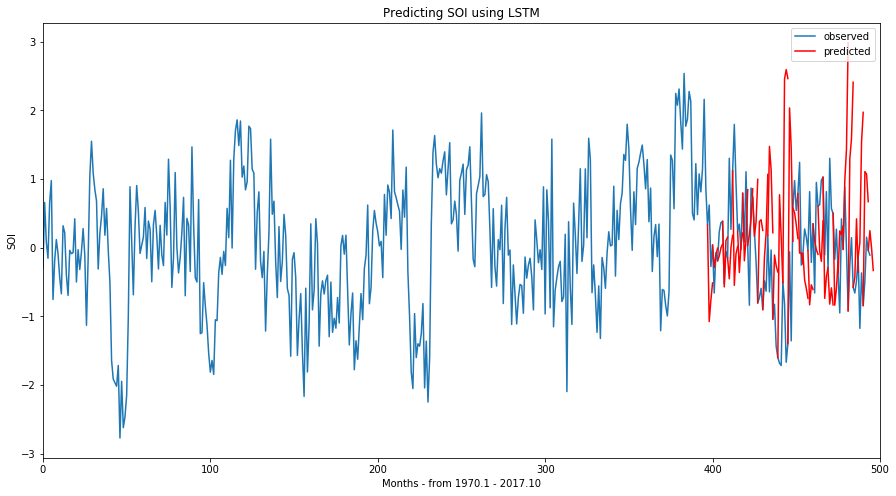

In [68]:
plot_forecasts(df['SOI'].values, forecasts, test.shape[0] + ahead - 1, 0, 500, ahead)